<a href="https://colab.research.google.com/github/tailorfenil/CV_3_Assignment/blob/main/CV_3_Assignment_Solution_sol.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os

local_assets_b = False

if local_assets_b:
  assets_dir = "/content/assignment_assets/"

  if not os.path.isdir(assets_dir):
    assert os.path.isfile("assets.zip")
    os.system("unzip assets.zip")
else:
  from google.colab import drive
  drive.mount('/content/drive')
  assets_dir = '/content/drive/MyDrive/CV_3/'

MessageError: Error: credential propagation was unsuccessful

### Unzip the Dataset

In [ ]:
import zipfile

# Path to the zip file you want to unzip
zip_file_path = assets_dir + "AT&T.zip"

# Target folder where you want to extract the contents
target_folder = "/content/dataset"

# Unzip the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
   zip_ref.extractall(target_folder)

# assert the folder exists
assert os.path.isdir(target_folder + '/AT&T'), "The unzipped folder cannot be found"

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader, Dataset
from torchvision.models import vgg16
from torchvision.datasets import ImageFolder
import numpy as np
import random
import torchvision.transforms as transforms
import torch.nn.functional as F

In [ ]:
vgg = vgg16(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:05<00:00, 107MB/s] 


In [ ]:
training_dir = "/content/dataset/AT&T/train/"
testing_dir = "/content/dataset/AT&T/test/"

## Siamese Network with VGG backbone

The below class defines a VGG backbone for the Siamese Network where we replace the last layer from the VGG model and then add a few dense layers to it along with regularization using Dropout and Batch Normalization.

In [ ]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        """
        Siamese Network with VGG-16 backbone for image similarity comparison.

        The network consists of a VGG-16 model with the last layer removed, followed by fully connected layers
        to extract features from input images. The extracted features are then used to compute image similarity.

        """
        super(SiameseNetwork, self).__init__()
        vgg = vgg16(pretrained=True)
        # Get the list of layers in the VGG-16 model.
        layers = list(vgg.children())
        # Remove the last layer from the list of layers.
        layers = layers[:-1]

        # Create a new model from the list of layers.
        self.backbone = torch.nn.Sequential(*layers) # This is the VGG backbone
        self.fc1 = nn.Sequential(
          nn.Linear(25088, 2048),
          nn.BatchNorm1d(2048),
          nn.ReLU(inplace=True),
          nn.Dropout(0.5),
          nn.Linear(2048, 512),
          nn.BatchNorm1d(512),
          nn.ReLU(inplace=True),
          nn.Dropout(0.5),
          nn.Linear(512, 5)
        )
        self.bn1 = nn.BatchNorm1d(25088)
        self.bn2 = nn.BatchNorm1d(5)

    def forward_on_single_image(self, x):
        """
        Perform forward pass for a single input image.

        Parameters:
            x (torch.Tensor): The input image tensor.

        Returns:
            torch.Tensor: The output feature tensor obtained after passing through the network layers.

        """
        x = self.backbone(x)
        # flatten the features
        x = x.view(x.size()[0], -1)
        x = self.bn1(x)
        x = self.fc1(x)
        x = self.bn2(x)
        return x

    def forward(self, input1, input2, input3):
        """
        Perform forward pass for a pair of input images.

        Parameters:
            input1 (torch.Tensor): The first input image tensor.
            input2 (torch.Tensor): The second input image tensor.

        Returns:
            tuple: A tuple containing the output feature tensors obtained after passing each input image
                   through the network.

        """
        output1 = self.forward_on_single_image(input1)
        output2 = self.forward_on_single_image(input2)
        output3 = self.forward_on_single_image(input3)
        return output1, output2, output3


## Siamese Dataset
We create a dataset from the images we have received where we create a dataset that contains three faces, in which 2 are similar and the 3rd is dissimilar thus helping train the Siamese Network to discern the differences between the 2 images that are different and the similarity between the 2 images which are similar.

In [ ]:
# Siamese Network Dataset
class SiameseNetworkDataset(Dataset):
    """
    Custom dataset for Siamese Network training.

    This dataset randomly samples pairs of images from the given input dataset, along with their corresponding labels
    indicating whether the images belong to the same class or not. It is used for training Siamese Networks which
    learn to compare and measure similarity between two input images.

    Parameters:
        dataset (Dataset): The original (PyTorch) dataset containing images and their labels.

    """
    def __init__(self, dataset):
        """
        Initialize the Siamese Network dataset.

        Parameters:
            dataset (Dataset): The original (PyTorch) dataset containing images and their labels.

        """
        self.dataset = dataset
        self.labels = torch.arange(len(dataset))

    def __getitem__(self, index):
        """
        Get a single sample from the Siamese Network dataset.

        Parameters:
            index (int): The index of the sample to retrieve.

        Returns:
            tuple: A tuple containing three images. The first element is the anchor image (img1), the second element is
                   the image which has the same label as the first image i.e. the positive image and the third element
                   is the image which has a different label than the first image i.e. the negative image.

        """
        anchor, label1 = self.dataset[index]
        # Randomly choose a different image with the same label
        while True:
            index2 = torch.randint(0, len(self.dataset), (1,))
            positive, label2 = self.dataset[index2]

            if label2 == label1:
              break


        # Randomly choose a different image with a different label
        while True:
            index3 = torch.randint(0, len(self.dataset), (1,))
            negative, label3 = self.dataset[index3]

            if label3 != label1:
                break

        return anchor, positive, negative

    def __len__(self):
        """
        Get the total number of samples in the dataset.

        Returns:
            int: The total number of samples in the dataset.

        """
        return len(self.dataset)


### Setting the Transformations

In [ ]:
# Setting the transformations
transform=transforms.Compose([transforms.Resize((100,100)),
                              transforms.ToTensor()
                            ])

### Dataset

Datasets are the collections of your training, validation, and test data. They consist of input samples and their corresponding target labels (for supervised learning). In PyTorch, datasets are typically created using custom classes inheriting from `torch.utils.data.Dataset`. You load your data into this class, allowing easy access during training.

In [ ]:
train_dataset = ImageFolder(training_dir, transform=transform)
test_dataset = ImageFolder(testing_dir, transform=transform)

print(len(train_dataset), len(test_dataset))

# Create Siamese datasets
train_siamese_dataset = SiameseNetworkDataset(train_dataset)
test_siamese_dataset = SiameseNetworkDataset(test_dataset)

370 30


### Dataloaders

Data Loaders wrap your dataset and provide functionalities for iterating through batches of data during training. They handle shuffling, batching, and parallel data loading, optimizing the data pipeline.

In [ ]:
# Create data loaders
batch_size = 64
test_batch_size = 1

train_loader = DataLoader(train_siamese_dataset, batch_size=batch_size, shuffle=True, num_workers=8)
test_loader = DataLoader(test_siamese_dataset, batch_size=test_batch_size, shuffle=False)

print("Train Dataset for Siamese Network created.", len(train_siamese_dataset))
print("Test Dataset for Siamese Network created.", len(test_siamese_dataset))

Train Dataset for Siamese Network created. 370
Test Dataset for Siamese Network created. 30


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


### Loss Function

Loss functions measure the difference between the predicted output and the actual target values. Common loss functions include Cross-Entropy Loss for classification tasks and Mean Squared Error for regression tasks.

### Defining the Triplet Loss Function

The Triplet Loss function is a key component in training Siamese Networks and related architectures for learning similarity and dissimilarity among data points. Similar to the Contrastive Loss, the Triplet Loss aims to shape the embedding space in a way that similar samples are closer together, while dissimilar samples are pushed farther apart.

In the context of the Triplet Loss, each training sample is referred to as an "anchor." For each anchor, we identify a "positive" sample (similar to the anchor) and a "negative" sample (dissimilar to the anchor). The goal of the Triplet Loss is to ensure that the distance between the anchor and the positive sample is smaller than the distance between the anchor and the negative sample by a certain margin.

Mathematically, for an anchor sample \(A\), a positive sample \(P\), and a negative sample \(N\), the Triplet Loss is computed as:

$$L(A, P, N) = max ( | f(A) - f(P) |^2 - | f(A) - f(N) |^2 + margin, 0 )$$

Here, f(.) represents the embedding function learned by the neural network, and \(| . |\) denotes the Euclidean distance between the embedded vectors. The margin is a hyperparameter that specifies the minimum desired separation between positive and negative samples.

In summary, the Triplet Loss guides the network to learn embeddings in such a way that the positive sample is pulled closer to the anchor while the negative sample is pushed away. This encourages the network to map similar samples together in the embedding space and dissimilar samples apart, resulting in meaningful representations that capture the inherent structure of the data's similarity relationships.

In [ ]:
class TripletLoss(nn.Module):
    """
    Triplet Loss function for training Siamese Networks with triplet sampling.

    The Triplet Loss encourages the model to minimize the distance between the anchor and the positive example
    while maximizing the distance between the anchor and the negative example. This helps in learning a suitable
    embedding space where similar examples are closer and dissimilar examples are farther apart.

    Parameters:
        margin (float): The margin value that defines the desired separation between positive and negative pairs.

    """
    def __init__(self, margin=1.0):
        super(TripletLoss, self).__init__()
        self.margin = margin


    def forward(self, anchor, positive, negative):
        """
        Compute the Triplet Loss based on the anchor, positive, and negative examples.

        Parameters:
            anchor (torch.Tensor): Embeddings of the anchor examples.
            positive (torch.Tensor): Embeddings of the positive examples.
            negative (torch.Tensor): Embeddings of the negative examples.

        Returns:
            torch.Tensor: Computed Triplet Loss.

        """
        anchor = F.normalize(anchor, p=2, dim=1)
        positive = F.normalize(positive, p=2, dim=1)
        negative = F.normalize(negative, p=2, dim=1)
        # Calculate the Euclidean distance between the pairs
        distance_positive = F.pairwise_distance(anchor, positive, keepdim=True)
        distance_negative = F.pairwise_distance(anchor, negative, keepdim=True) # exp keepdim makes sure the output is Nx1 instead of N
        loss = torch.max(distance_positive - distance_negative + self.margin, torch.zeros_like(distance_positive)) # exp
        loss = loss.mean()
        return loss

In [ ]:
# Define the loss function and optimizer
triplet_loss = TripletLoss()

In [ ]:
# Set device (GPU if available, else CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create an instance of the Siamese Network with VGG16 backbone
model = SiameseNetwork().to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:06<00:00, 81.5MB/s]


### Optimizer

Optimizers are algorithms that adjust the model's parameters during training to minimize the loss function. Common optimizers include SGD (Stochastic Gradient Descent), Adam, and RMSprop.

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=0.0005)

In [ ]:
def train_batch(epoch, model, optimizer, loss_history):
    print("epoch ", epoch)
    model.train()
    train_loss = 0

    for batch_idx, batch in enumerate(train_loader):

        anchor, positive, negative = batch
        anchor = anchor.to(device) # Move the anchor image to the device
        positive = positive.to(device) # Move the positive image to the device
        negative = negative.to(device) # Move the negative image to the device

        optimizer.zero_grad()  # Zero the gradients to prevent accumulation from previous iterations
        output_anchor, output_pos, output_neg = model(anchor, positive, negative)  # Forward pass: get the output feature vectors for all three images
        loss = triplet_loss(output_anchor, output_pos, output_neg) # Calculate the Triplet Loss
        loss.backward()  # Backward pass: compute gradients of the loss with respect to model parameters
        optimizer.step()  # Update the model's parameters using the computed gradients

        train_loss += loss.item()

    print('Train Loss: %.3f'
                         % (train_loss/(batch_idx+1)))
    loss_history.append(train_loss)


In [ ]:
def validate_batch(epoch, model, loss_history):
    global best_acc
    model.eval()
    test_loss = 0

    with torch.no_grad():
        for batch_idx, batch in enumerate(test_loader):
            anchor, positive, negative = batch
            anchor = anchor.to(device) # Move the anchor image to the device
            positive = positive.to(device) # Move the positive image to the device
            negative = negative.to(device) # Move the negative image to the device

            output_anchor, output_pos, output_neg = model(anchor, positive, negative)  # Forward pass: get the output feature vectors for all three images
            loss = triplet_loss(output_anchor, output_pos, output_neg) # Calculate the Triplet Loss

            test_loss += loss.item()

    print('Val Loss: %.3f'
                 % (test_loss/(batch_idx+1)))
    loss_history.append(test_loss)

### Training the Model

In [ ]:
# Initialize lists to track training progress
train_loss_history = [] # List to store the loss value during training
val_loss_history = [] # List to store the loss value during validation

# Training loop
num_epochs = 100

for epoch in range(num_epochs):
    train_batch(epoch, model, optimizer, train_loss_history)
    validate_batch(epoch, model, val_loss_history)

epoch  0
Train Loss: 0.770
Val Loss: 0.974
epoch  1
Train Loss: 0.452
Val Loss: 0.878
epoch  2
Train Loss: 0.433
Val Loss: 0.951
epoch  3
Train Loss: 0.399
Val Loss: 0.777
epoch  4
Train Loss: 0.352
Val Loss: 0.915
epoch  5
Train Loss: 0.305
Val Loss: 0.869
epoch  6
Train Loss: 0.304
Val Loss: 0.925
epoch  7
Train Loss: 0.267
Val Loss: 0.994
epoch  8
Train Loss: 0.289
Val Loss: 0.937
epoch  9
Train Loss: 0.245
Val Loss: 0.945
epoch  10
Train Loss: 0.217
Val Loss: 0.854
epoch  11
Train Loss: 0.193
Val Loss: 0.985
epoch  12
Train Loss: 0.208
Val Loss: 0.994
epoch  13
Train Loss: 0.205
Val Loss: 0.943
epoch  14
Train Loss: 0.203
Val Loss: 0.490
epoch  15
Train Loss: 0.207
Val Loss: 0.434
epoch  16
Train Loss: 0.196
Val Loss: 0.989
epoch  17
Train Loss: 0.162
Val Loss: 0.758
epoch  18
Train Loss: 0.134
Val Loss: 0.552
epoch  19
Train Loss: 0.172
Val Loss: 0.359
epoch  20
Train Loss: 0.146
Val Loss: 0.658
epoch  21
Train Loss: 0.160
Val Loss: 0.461
epoch  22
Train Loss: 0.139
Val Loss: 0.17

### Plotting the loss

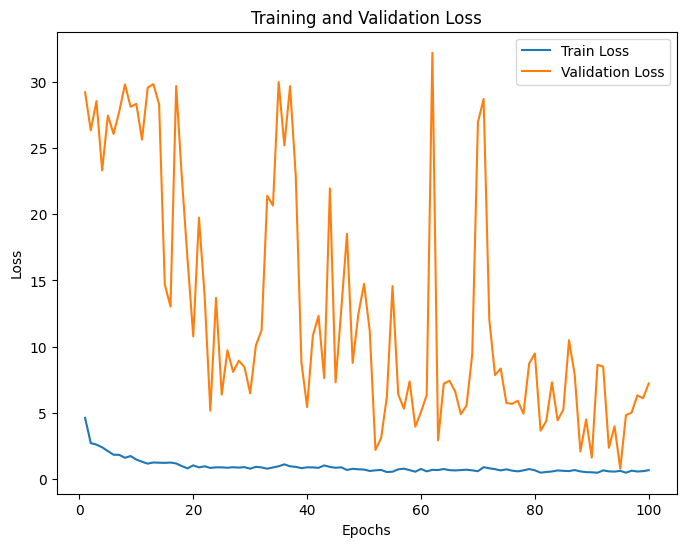

In [ ]:
import matplotlib.pyplot as plt

# Plot the loss values using Matplotlib (optional)
epochs = list(range(1, len(train_loss_history) + 1))
plt.figure(figsize=(8, 6))
plt.plot(epochs, train_loss_history, label='Train Loss')
plt.plot(epochs, val_loss_history, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

### Save the model

In [ ]:
state_dict = model.state_dict()
torch.save(state_dict, assets_dir + "assignment_model_dict.pt")

### Load the model

In [ ]:
file_path = assets_dir + 'assignment_model_dict.pt'
model = SiameseNetwork()
model.load_state_dict(torch.load(file_path))
model = model.to(device)

### Evaluating the Model

The Euclidean distance is a commonly used metric to quantify the similarity between two feature vectors in image analysis. It calculates the straight-line distance between the points in the feature space. Smaller distances indicate higher similarity, while larger distances indicate dissimilarity. The Euclidean distance metric is intuitive and straightforward to compute, making it widely used in various applications such as image retrieval and clustering.

In [ ]:
import torchvision
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt

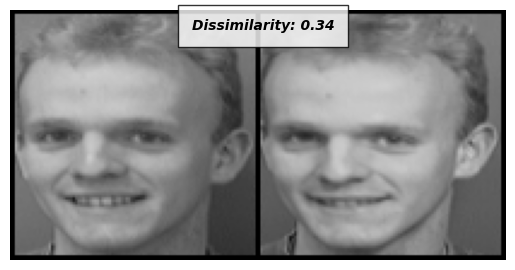

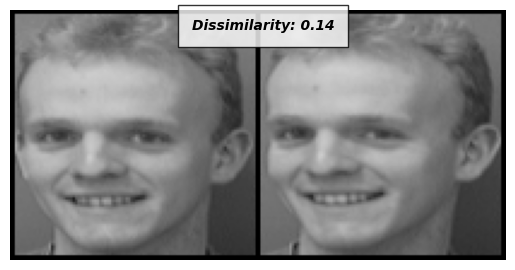

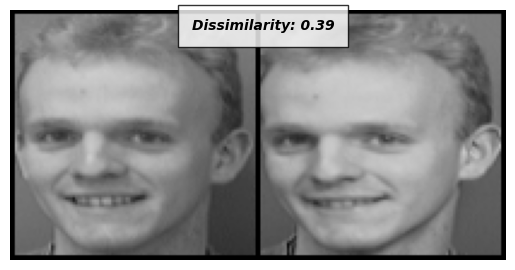

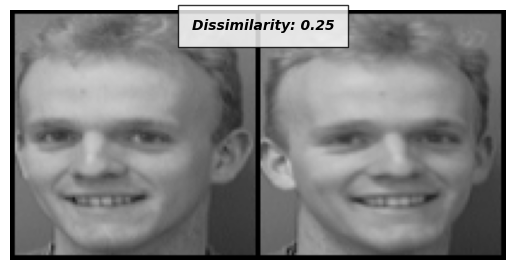

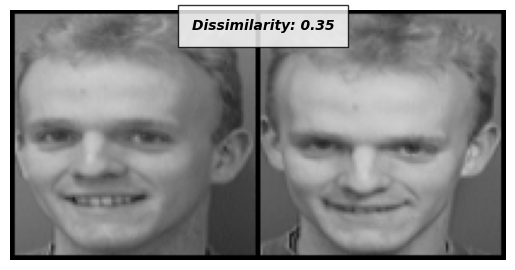

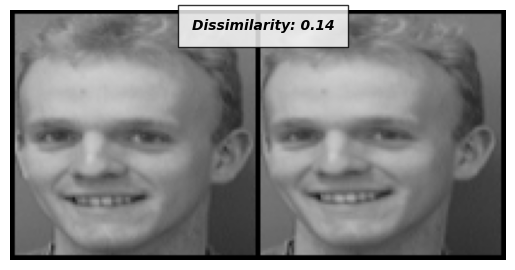

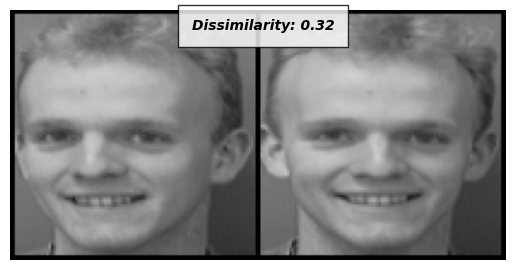

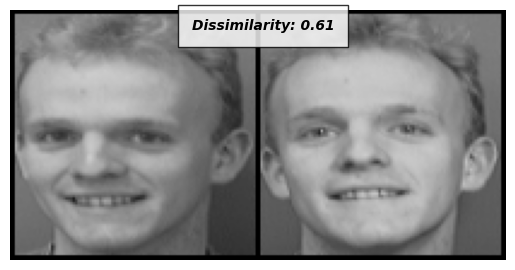

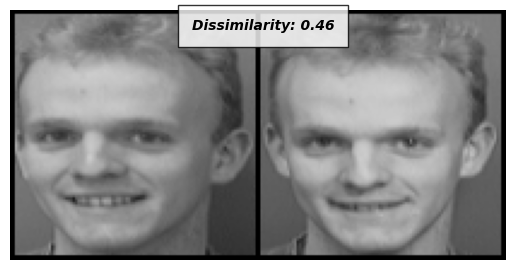

In [ ]:
# Evaluation
model.eval()

with torch.no_grad():
    # Note: Each batch contains only 1 image for test loader as set above
    for i, batch in enumerate(test_loader):

        # setting x0 to the first image which will be used to compare against other 9 images
        if i == 0:
          x0,_,_ = batch
          image1 = x0
          x0 = x0.to(device)
          continue

        # Limiting to 10 images
        if i == 10:
          break

        _,x1,_ = batch
        image2 = x1
        x1 = x1.to(device)
        # Concatenate two images side by side for visualization
        concatenated = torch.cat((image1,image2),0)
        # Forward pass through the Siamese Network to get the output feature vectors for both images
        output1 = model.forward_on_single_image(x0)
        output2 = model.forward_on_single_image(x1)

        # detach the tensor and move it to the CPU
        x1 = x1.detach().cpu()

        # Calculate the Euclidean distance between the output feature vectors
        euclidean_distance = F.pairwise_distance(output1, output2)
        concatenated_img = torchvision.utils.make_grid(concatenated)
        concatenated_img_text = 'Dissimilarity: {:.2f}'.format(euclidean_distance.item())

        npimg = concatenated_img.numpy()
        plt.axis("off")
        if concatenated_img_text:
            plt.text(75, 8, concatenated_img_text, style='italic',fontweight='bold',
                bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
        plt.imshow(np.transpose(npimg, (1, 2, 0)))
        plt.show()

    x0 = x0.detach().cpu()

Cosine Similarity is a widely employed metric for assessing the similarity between two feature vectors in image analysis and other domains. It quantifies the cosine of the angle between two vectors in the feature space. Higher cosine similarity values indicate greater alignment in direction and orientation, implying higher similarity between the vectors.

Compared to Euclidean distance, which measures the straight-line distance between points, Cosine Similarity focuses on the angle between vectors, disregarding their magnitudes. This means that even if the vectors have different lengths, they can still exhibit high cosine similarity if they are pointing in the same general direction.

Mathematically, the Cosine Similarity between two vectors \(A\) and \(B\) is computed as:

Cosine Similarity(A, B) = A . B / (|A\| * \|B\|)

Where \(A . B\) represents the dot product of the two vectors, and \(\|A\|\) and \(\|B\|\) represent the magnitudes (or lengths) of the respective vectors.

Cosine Similarity values range between -1 and 1. A Cosine Similarity of 1 indicates that the vectors are perfectly aligned and have the same orientation. A Cosine Similarity of -1 indicates that the vectors are perfectly aligned but have opposite orientations. A Cosine Similarity of 0 implies that the vectors are orthogonal, indicating no similarity in direction.

Cosine Similarity finds use in diverse applications like text analysis, recommendation systems, and image retrieval. Its ability to measure the direction of similarity while ignoring magnitude variations makes it particularly suited for scenarios where magnitude differences are not as relevant as the alignment of features.

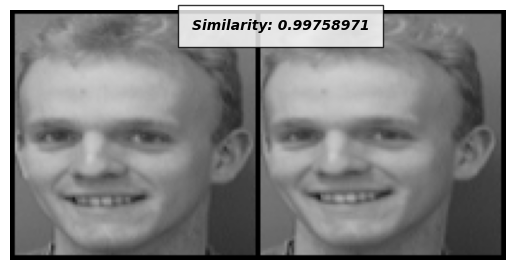

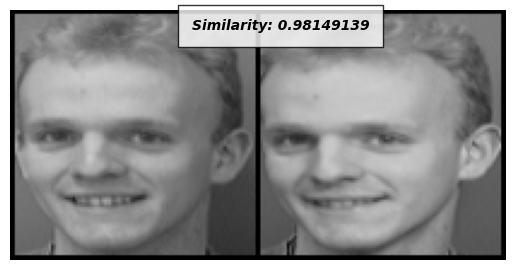

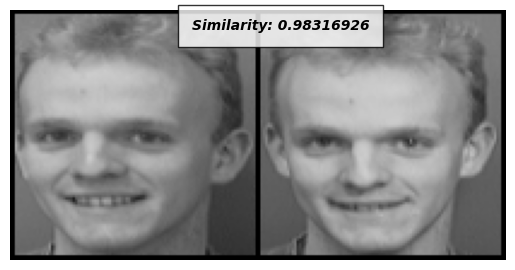

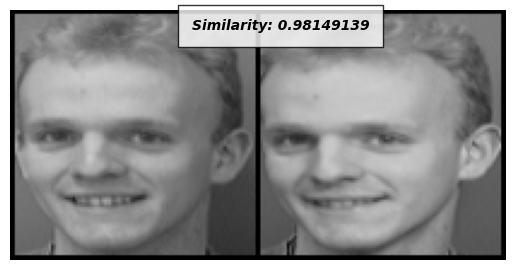

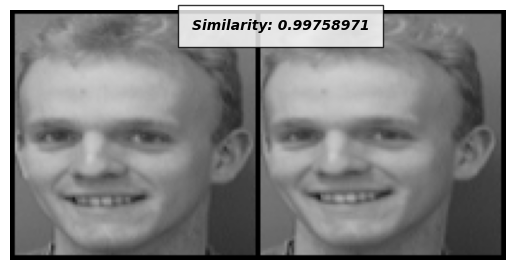

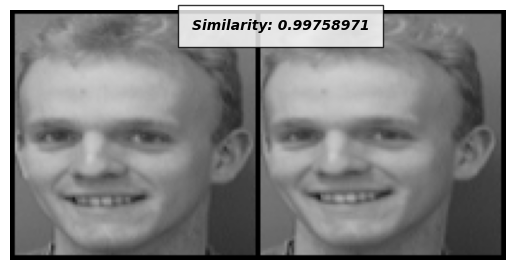

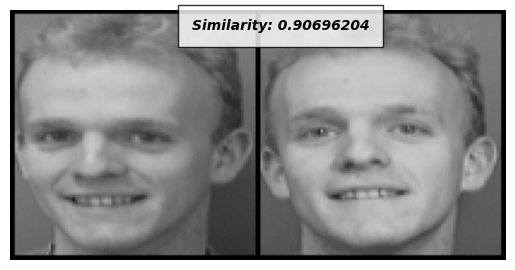

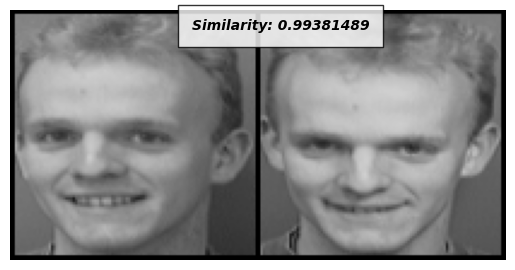

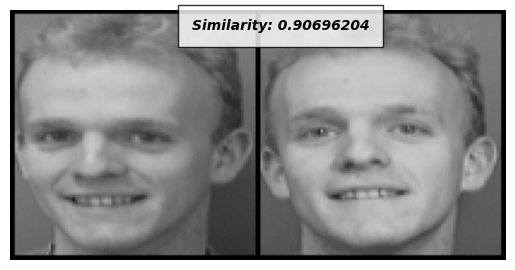

In [ ]:
# Using Cosine Similarity
model.eval()

with torch.no_grad():
    # Note: Each batch contains only 1 image for test loader as set above
    for i, batch in enumerate(test_loader):
        # setting x0 to the first image which will be used to compare against other 9 images
        if i == 0:
          x0,_,_ = batch
          image1 = x0
          x0 = x0.to(device)
          continue

        # Limiting to 10 images
        if i == 10:
          break

        _,x1,_ = batch
        image2 = x1
        x1 = x1.to(device)

        # Concatenate two images side by side for visualization
        concatenated = torch.cat((image1,image2),0)

        # Forward pass through the Siamese Network to get the output feature vectors for both images
        output1 = model.forward_on_single_image(x0)
        output2 = model.forward_on_single_image(x1)

        # detach the tensor and move it to the CPU
        x1 = x1.detach().cpu()

        # Calculate the Cosine Similarity between the output feature vectors
        cosine_similarity = F.cosine_similarity(output1, output2)
        concatenated_img = torchvision.utils.make_grid(concatenated)
        concatenated_img_text = 'Similarity: {:.8f}'.format(cosine_similarity.item())

        npimg = concatenated_img.numpy()
        plt.axis("off")
        if concatenated_img_text:
            plt.text(75, 8, concatenated_img_text, style='italic',fontweight='bold',
                bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
        plt.imshow(np.transpose(npimg, (1, 2, 0)))
        plt.show()

    x0 = x0.detach().cpu()

### Finding Top-5 Images

torch.Size([30, 6])
Top 5 similar image vectors for image: 0:
Similarity value: 0.997740030
Similarity value: 0.997589707
Similarity value: 0.993814886
Similarity value: 0.985601127
Similarity value: 0.984987497


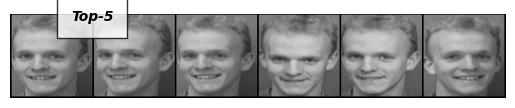

Top 5 similar image vectors for image: 1:
Similarity value: 0.962073803
Similarity value: 0.946508348
Similarity value: 0.939361513
Similarity value: 0.937901080
Similarity value: 0.918188930


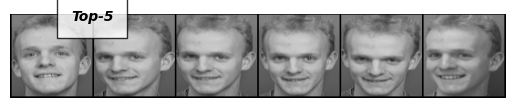

Top 5 similar image vectors for image: 2:
Similarity value: 0.995847583
Similarity value: 0.975104094
Similarity value: 0.974839628
Similarity value: 0.958430111
Similarity value: 0.949532866


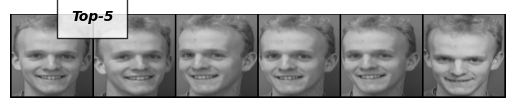

Top 5 similar image vectors for image: 3:
Similarity value: 0.995847583
Similarity value: 0.986922085
Similarity value: 0.984987497
Similarity value: 0.972390532
Similarity value: 0.967468202


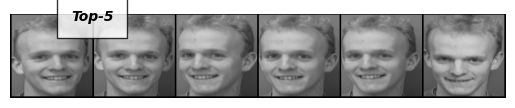

Top 5 similar image vectors for image: 4:
Similarity value: 0.997589707
Similarity value: 0.997278810
Similarity value: 0.996146142
Similarity value: 0.991908371
Similarity value: 0.989898384


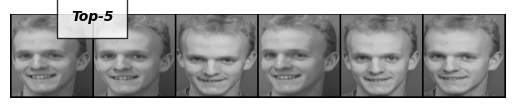

Top 5 similar image vectors for image: 5:
Similarity value: 0.998255670
Similarity value: 0.995875716
Similarity value: 0.995644093
Similarity value: 0.987504721
Similarity value: 0.981491387


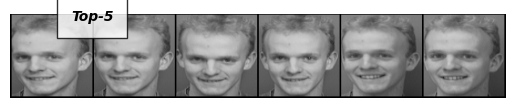

Top 5 similar image vectors for image: 6:
Similarity value: 0.998255670
Similarity value: 0.997417688
Similarity value: 0.995993078
Similarity value: 0.989898384
Similarity value: 0.985601127


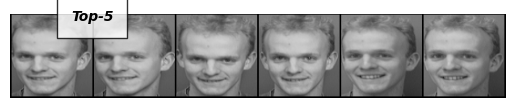

Top 5 similar image vectors for image: 7:
Similarity value: 0.997740030
Similarity value: 0.996146142
Similarity value: 0.992670298
Similarity value: 0.986922085
Similarity value: 0.982721150


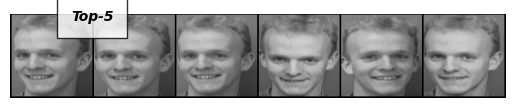

Top 5 similar image vectors for image: 8:
Similarity value: 0.997417688
Similarity value: 0.997278810
Similarity value: 0.996080577
Similarity value: 0.995875716
Similarity value: 0.993814886


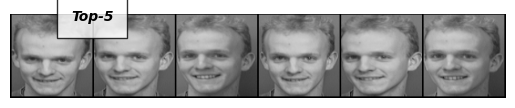

Top 5 similar image vectors for image: 9:
Similarity value: 0.996080577
Similarity value: 0.995993078
Similarity value: 0.995644093
Similarity value: 0.991908371
Similarity value: 0.983169258


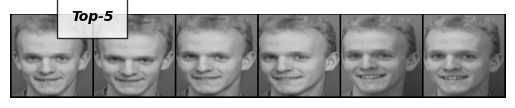

Top 5 similar image vectors for image: 10:
Similarity value: 0.995622993
Similarity value: 0.980208039
Similarity value: 0.942778885
Similarity value: 0.931452513
Similarity value: 0.926798284


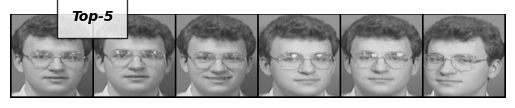

Top 5 similar image vectors for image: 11:
Similarity value: 0.999466598
Similarity value: 0.998615444
Similarity value: 0.998119056
Similarity value: 0.996234775
Similarity value: 0.996206105


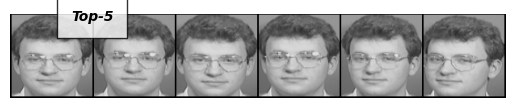

Top 5 similar image vectors for image: 12:
Similarity value: 0.980208039
Similarity value: 0.960361302
Similarity value: 0.933747172
Similarity value: 0.904902518
Similarity value: 0.901004672


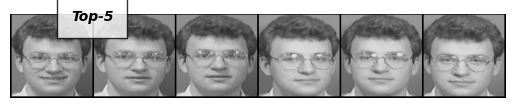

Top 5 similar image vectors for image: 13:
Similarity value: 0.995622993
Similarity value: 0.960361302
Similarity value: 0.949479222
Similarity value: 0.949017406
Similarity value: 0.948449850


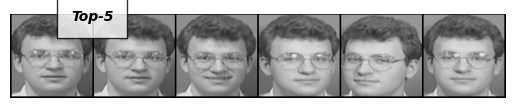

Top 5 similar image vectors for image: 14:
Similarity value: 0.998615444
Similarity value: 0.996899366
Similarity value: 0.996518910
Similarity value: 0.994801462
Similarity value: 0.990384161


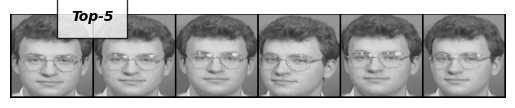

Top 5 similar image vectors for image: 15:
Similarity value: 0.998861074
Similarity value: 0.998119056
Similarity value: 0.997533262
Similarity value: 0.997074604
Similarity value: 0.994801462


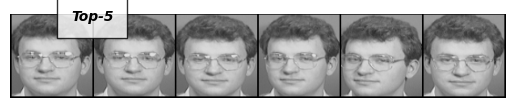

Top 5 similar image vectors for image: 16:
Similarity value: 0.999466598
Similarity value: 0.998861074
Similarity value: 0.997978628
Similarity value: 0.996899366
Similarity value: 0.995912790


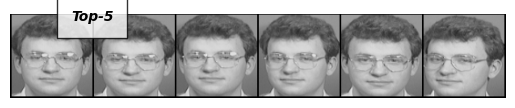

Top 5 similar image vectors for image: 17:
Similarity value: 0.997978628
Similarity value: 0.997533262
Similarity value: 0.996234775
Similarity value: 0.993520617
Similarity value: 0.990384161


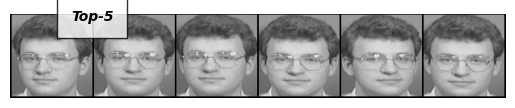

Top 5 similar image vectors for image: 18:
Similarity value: 0.993520617
Similarity value: 0.990544140
Similarity value: 0.987763345
Similarity value: 0.985209703
Similarity value: 0.981398046


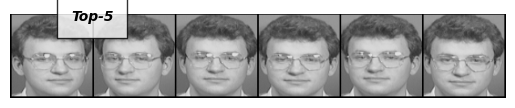

Top 5 similar image vectors for image: 19:
Similarity value: 0.997074604
Similarity value: 0.996518910
Similarity value: 0.996206105
Similarity value: 0.995912790
Similarity value: 0.993927121


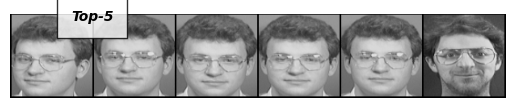

Top 5 similar image vectors for image: 20:
Similarity value: 0.999686539
Similarity value: 0.999272466
Similarity value: 0.999001324
Similarity value: 0.998467922
Similarity value: 0.997791171


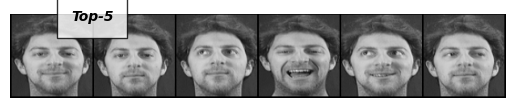

Top 5 similar image vectors for image: 21:
Similarity value: 0.998961091
Similarity value: 0.998052835
Similarity value: 0.993798077
Similarity value: 0.991795480
Similarity value: 0.990276039


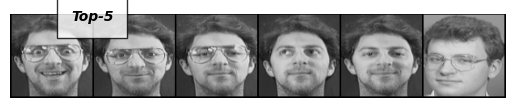

Top 5 similar image vectors for image: 22:
Similarity value: 0.999389768
Similarity value: 0.999247730
Similarity value: 0.999001324
Similarity value: 0.998955786
Similarity value: 0.998643756


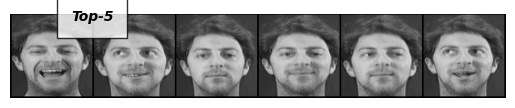

Top 5 similar image vectors for image: 23:
Similarity value: 0.999693990
Similarity value: 0.999619365
Similarity value: 0.999389768
Similarity value: 0.999205589
Similarity value: 0.998467922


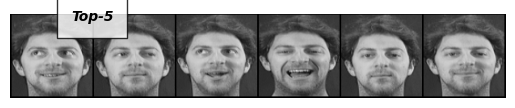

Top 5 similar image vectors for image: 24:
Similarity value: 0.999407470
Similarity value: 0.998961091
Similarity value: 0.993927121
Similarity value: 0.993818045
Similarity value: 0.991435111


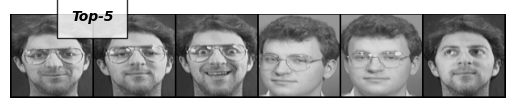

Top 5 similar image vectors for image: 25:
Similarity value: 0.999407470
Similarity value: 0.998052835
Similarity value: 0.991146326
Similarity value: 0.990892768
Similarity value: 0.990007877


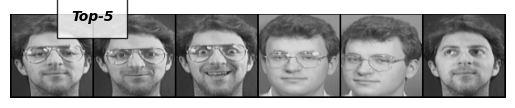

Top 5 similar image vectors for image: 26:
Similarity value: 0.999621153
Similarity value: 0.999619365
Similarity value: 0.998643756
Similarity value: 0.997933149
Similarity value: 0.996634245


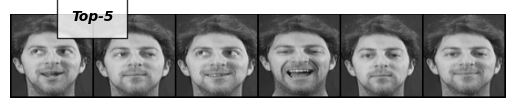

Top 5 similar image vectors for image: 27:
Similarity value: 0.999693990
Similarity value: 0.999621153
Similarity value: 0.999033391
Similarity value: 0.998955786
Similarity value: 0.997791171


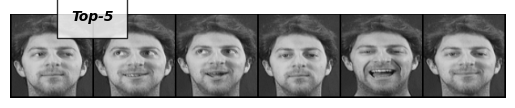

Top 5 similar image vectors for image: 28:
Similarity value: 0.999686539
Similarity value: 0.999247730
Similarity value: 0.999205589
Similarity value: 0.999033391
Similarity value: 0.998852551


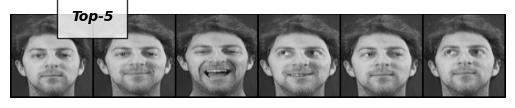

Top 5 similar image vectors for image: 29:
Similarity value: 0.999272466
Similarity value: 0.998852551
Similarity value: 0.998629808
Similarity value: 0.996953487
Similarity value: 0.996584654


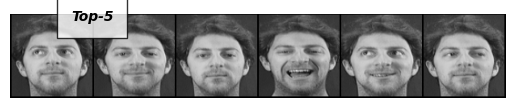

In [ ]:
# Using Cosine Similarity - Top K matches
import torchvision
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
from itertools import tee

# Evaluation
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    feature_vectors = []
    images = []
    try:
      # Note: Each batch contains only 1 image for test loader as set above
      for i, batch in enumerate(test_loader):
        x0,_,_ = batch
        images.append(x0)
        x0 = x0.to(device)
        output1 = model.forward_on_single_image(x0)
        x0 = x0.detach().cpu()
        feature_vectors.append(output1)
    except StopIteration:
      pass


    # We are calculating the cosine similarity for each image against all other images, and since there are 30 images and this will run 2 for loops (nested) generating 900 values
    similarities = torch.stack([F.cosine_similarity(feature_vectors[i], feature_vectors[j]) for i in range(len(feature_vectors)) for j in range(len(feature_vectors))])

    # Reshape similarities tensor to have dimensions (num_images, num_images) i.e. since there are 900 values it will be reshaped to 30X30
    similarities = similarities.view(len(feature_vectors), len(feature_vectors))

    # Find the indices of the top 5 similar image vectors for each image vector
    top_k_indices = torch.topk(similarities, k=6, dim=1)[1]

    # This will print [30, 6] so for each image we are finding the top 6 (and not 5) images as the first image is the same image itself.
    print(top_k_indices.shape)

    # Loop through each image vector and its top 5 similar image vectors
    for i, similar_indices in enumerate(top_k_indices):
        print(f"Top 5 similar image vectors for image: {i}:")
        concatenated = images[i] # The actual image is being added first
        for index in similar_indices:
            if index != i:  # Exclude the image vector itself (so that we can get the other 5 similar images)
                concatenated = torch.cat((concatenated,images[index]),0)
                similarity_value = similarities[i, index]
                print(f"Similarity value: {similarity_value:.9f}")
        concatenated_img = torchvision.utils.make_grid(concatenated)
        concatenated_img_text = 'Top-5'
        npimg = concatenated_img.numpy()
        plt.axis("off")
        if concatenated_img_text:
            plt.text(75, 8, concatenated_img_text, style='italic',fontweight='bold',
                bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
        plt.imshow(np.transpose(npimg, (1, 2, 0)))
        plt.show()
